In [1]:
#!/usr/bin/env python
''' DCAPE.ipynb

    This program calculated Downward CAPE (DCAPE) from CONUS404 output

'''

from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
from datetime import timedelta
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import shapefile as shp
import matplotlib.path as mplPath
from thermodynamics_p3 import Theta
import netCDF4
import metpy
import wrf
import warnings
warnings.filterwarnings('ignore')
from scipy.interpolate import interp1d
import time
import wrf

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr
import sys
from tqdm import tqdm

### Code from - https://github.com/jillianndufort/Calculation-for-DCAPE/blob/main/Code%20for%20MetPy%20Proj.py

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#Import necessary modules
import numpy as np
import pandas as pd
import metpy as mp
import metpy.calc as mpcalc
import metpy.constants as mpconsts
import matplotlib.pyplot as plt
from metpy.units import units
from mpl_toolkits.axisartist import Subplot
from matplotlib.ticker import FuncFormatter, Formatter
from datetime import datetime#, timezone
from siphon.simplewebservice.wyoming import WyomingUpperAir
import time
import statistics

##############
## USER INPUTS
##############
# change date and site to test any archived sounding 
date = '2020081012' #str 'YYYYMMDDHH' of sounding
site =  'FGZ' #3 letter station ID (ie ILX or OUN)

## #  # # # # # # # # # # # #  # #
# Data Prep
###########
def readSounding (datestr, station):
    ''' Download the data from the wyoming site and prep for future use
    '''
    #read in the data 
    date= datetime.strptime(datestr, '%Y%m%d%H')
    df=WyomingUpperAir.request_data(date, station)
    
    #drop unnesesary columns from our dataframe 
    df=df.drop(columns=['elevation', 'direction','speed', 'u_wind','v_wind', 'station', 
                        'station_number', 'time', 'latitude','longitude'])
    #shorten the names of the remaining columns
    df=df.rename(columns={"temperature":"tempC", "dewpoint":"dewC", "height":"hght", "pressure":"press"})

    #convert temp and dew to kelvin
    df['tempK'], df['dewK'] = df.tempC+273.15 , df.dewC+273.15
    return df

## #  # # # # # # # # # # # #  # #
##############
# Calculations
##############
def moist_lapse(t_start, press_start, delta_z, Eqn):
    '''Calculating the moist adiabatic lapse rate
    ---
    Inputs: 
        t_start: starting temperature in Kelvin
        press_start: starting pressure in hPa
        delta_z: height in meters
        Eqn: Equation used in the calculation of sat vapor pressure
    
    Outputs: 
        t_final: Final temperature at the next level in Kelvin
       '''
    #Det sat mixing ratio
    Ws= sat_mixing_ratio(press_start, t_start, Eqn)

    #Det moist lapse rate #t_start in kelvin
    g, Lv, Cp_d, Rd, E = mpconsts.g.m, mpconsts.Lv.m, mpconsts.Cp_d.m, (mpconsts.Rd.m*1000),  mpconsts.epsilon.m 
    M_L = g * ( (1 + ((Lv*Ws)/(Rd*t_start))) / (Cp_d + ((np.square(Lv)*Ws*E)/(np.square(t_start)*Rd))) )

    #Det next parcel point
    delta_t = M_L * delta_z #change in t (in K ) across the distance delta_z
    t_final = t_start + delta_t
    return t_final 

#**************
def sat_mixing_ratio(P, T, Eqn):
    """Calc mixing ratio: can specify one of three different sat vap pressure calculation methods
    ---
    Inputs:
        P: Pressure in hPa
        T: Temperature in Kelvin
        Eqn: Equation to use in the calculation of sat vap press
        
    Outputs: 
        Ws: saturation mixing ratio in kg/kg
    """
    #Calc es 
    e_s = sat_vap_press(T, Eqn)
    if Eqn == 'metpy': e_s = e_s.m
    #Calc the mixing ratio using the specified e_s as an input 
    Ws = .622 * (e_s / (P -e_s)) #mixing ratio (kg/kg) 
    return Ws

#**************
def Virtual_Temp( P, T, Eqn):
    """Calc the virtual temp using the saturation mixing ratio that was calculated
    ---
    Inputs: 
        P: Pressure in hPa
        T: Temperature in Kelvin
        Eqn: Equation to use in the calculation of sat vap press
        
    Outputs: 
        TV: Virtual Temperature in Kelvin  
    """
    #Calc the mixing ratio using the specified e_s as an input 
    Ws = sat_mixing_ratio(P, T, Eqn)

    #Convert temperature to virtual temperature (Input and output T is in K)
    TV = T * ( (1 + (Ws/mpconsts.epsilon.m)) / (1 + Ws))
    return TV

#**************
def thetae(P, T, Eqn):
    """Calculate theta-e using Eqn 2 from Bolton (1980)  
    theta_e = (Tc*(pv/pd)**(k_dry)) * np.exp((Lv*w)/(4190*Tc))
    ---
    Inputs: 
        Tc: Temperature in Celcius
        T: Temperature in Kelvin
        P: Pressure in hPa
        Eqn: Equation to use in the calculation of sat vap press
    
    Outputs:
        theta_e: Theta-e in Kelvin
    """
    #Define the constants 
    #Note: We found that Rd was printing out as Rd = 0.287, so we multiplied it by 1000
    Lv, Cp_d, Rd = mpconsts.Lv.m, mpconsts.Cp_d.m, (mpconsts.Rd.m*1000) 
    Cw = 4190 #specific heat of water
    Ws = sat_mixing_ratio(P, T, Eqn)
    Cw_d = Cp_d + (Ws * Cw) 

    #Plug into Eqn 2 from Bolton (1980)
    a = ((T-273.15) * (1000/P)**( Rd/Cw_d ))
    b = np.exp((Lv*Ws) / (Cw_d*(T-273.15)))
    theta_e = a * b
    
    theta_e = a * b
    return theta_e


## #  # # # # # # # # # # # #  # #
#####################
# DCAPE and e_s Calcs
#####################
def sat_vap_press(T, Eqn):
    ''' Calculate the saturation vapor pressure three seperate ways
    ---
    Inputs: 
        T: Temperature in Kelvin 
        Eqn: Equation to use in the saturation vapor pressure calculation
        
    Output:
        e_s: saturation vapor pressure
    '''
    #Used metpy as a way to check our values
    #Note: metpy uses Bolton (1980) in order to calculate saturation vapor pressure
    if Eqn == 'metpy':
        try: T=T.to_numpy()
        except: pass
        
        #Converting units
        Tk= T*units.degK
        e_s = mpcalc.saturation_vapor_pressure(Tk)
        return e_s

    # * * *
    ## Calc e_s using Eqn 23 from Alduchov and Eskridge (1996)
    elif Eqn == 'Magnus':
        Tc= T-273.15 #convert to C
        e_s = 6.1094 *np.exp( (17.625*Tc) / (Tc+243.04) )
        return e_s

    # * * *
    elif Eqn == 'Wexler':
        ## Calc e_s using Eqn from Wexler (1976)
        #Breaking down the equation
        a = ((-2.9912729 *(10**3)) * ((T)**(-2)))
        b = ((6.0170128 *(10**3)) * ((T)**(-1)))
        c = (1.887643845 *(10**1))
        d = ((2.8354721 *(10**-2)) * (T))
        e = ((1.7838301 *(10**-5)) * ((T)**(2)))
        f = ((8.4150417 *(10**-10)) * ((T)**(3)))
        g = ((4.4412543 *(10**-13)) * ((T)**(4)))
        h = ((2.858487 * (np.log(T))))
        #Calculating the saturation vapor pressure
        e_s= 0.01* np.exp( a-b+c-d+e-f+g+h )
        return e_s
     
    # * * *
    elif Eqn == 'Buck':
        ## Calc e_s using Eqn from Buck (1996) (for liquid water only)
        
        # Temperature converted to celcius
        Tc = T - 273.15 
        
        #Break down equation
        a1 = (18.678-(Tc/234.5))
        b1 = (Tc/(257.14+Tc))
        e_s = (6.1121*np.exp(a1*b1))
        return e_s

########
#**************
def DCAPE (data, ES, origin_method):
    """DCAPE will be calcuated using virtual temperature (and therefore the mixing ratio and saturation mixing ratio 
        calculated above. We will be checking to see which version of saturation vapor pressure will result in the most
        accurate DCAPE values
    ---
    Inputs:
        data: the sounding dataset that is read in 
        ES: Noting which saturation vapor pressure equation you would like to use
        origin_method: Noting which calculation you would like to use to find the source origin height 
                       (upper bounda of integration) for DCAPE
    
    Outputs:
        DCAPE: Downdraft CAPE (Convective Available Potential Engery) in J/kg
        calculation_time: The time it takes for the code to run; will help determine if the options are computationally expensive
    """
    
    calc_start_time = time.time()
    def DCAPE_origin(data, Eqn, method):
        """ Will let you choose between 3 different options for finding the source origin height
        ---
        Inputs:
            data: the sounding dataset that is read in 
            Eqn: Equation to use in the saturation vapor pressure calculation
            method: Noting which calculation you would like to use to dins the source origin height
            
        Outputs: 
            press_oforig: the pressure value of the source origin height in hPa
        """
        if method == 'DD_method1':
            '''this is the lowest thetae value in the sfc-400mb layer'''
            #only eval levels at which the pressure is greater than 400mb 
            sfc_to_400 = data.loc[data['press'] >= 400]
            #find the thetae-e at all the levels that matched the above criteria
            sfc_to_400_Te = thetae(sfc_to_400.press, sfc_to_400.tempK, Eqn) 
            #find which level the min thetae occurs at (from sfc to 400mb)
            row_oforig, Te_min = sfc_to_400_Te.idxmin(), sfc_to_400_Te.min()
            press_oforig = data.iloc[row_oforig]['press']
            return press_oforig

        
        elif method == 'DD_method2':   
            '''this is the lowest thetae value in 100mb averaged layers'''
            ##Group into 100 mb layers (label each group with number i in the colunmn layer_group)
            data['layer_group'] = np.nan
            i, start_p, end_p = 0, data['press'].iloc[0], data['press'].iloc[-1]
            
            while (start_p >= end_p):
                top_p = start_p - 100
                data.loc[(data['press'] <= start_p) & (data['press'] > top_p), 'layer_group'] = i
                i, start_p = i+1, top_p 

            #find the thetae-e at all the levels 
            data['Te'] = thetae(data.press, data.tempK, Eqn) 
            #Average the data via 100mb level groupings 
            data_averaged=data.groupby(pd.Grouper(key='layer_group')).mean()
            pressure_ave=data.groupby(pd.Grouper(key='layer_group')).median()
            #find which layer the min thetae occurs at 
            row_ofmin, Te_min = data_averaged['Te'].idxmin(), data_averaged['Te'].min()

            press_oforig = pressure_ave.loc[row_ofmin]['press']
            row_oforig = data.loc[data['press'] == press_oforig].index
            data=data.drop(columns=['layer_group'])
            return press_oforig

        elif method == 'DD_method3':   
            #Will be used to calculate the density weighted average DCAPE below
            press_oforig= data['press']   
            
            return press_oforig

    def DD_CAPE_CALC(data, sfc_press, upper_press, ES): 
        """ Using one of the options from above to calculate DCAPE
        ---
        Inputs: 
            data: the sounding dataset that is read in 
            sfc_press: surface pressure in hPa; lower bound of integration for DCAPE
            upper_press: upper level pressure in hPa; upper bound of integration for DCAPE
            ES: Noting which saturation vapor pressure equation you would like to use
            
        Output: 
            dcape: Downdraft CAPE in J/kg
        """
        # Trim data to only consider the levels within the identified layer
        # Flip order of the data to capture the descending motion of the parcel
        DD_layer = data.loc[(data['press'] <= sfc_press) & (data['press'] >= upper_press)].sort_values(by='press')
        ## Create the parcel profile for decent along a moist adiabat
        # # #  # # # #  # # #  # # # #  # # # # # #  # #  #  # #  # # 
        #calc parcel path temps (aka moist adiabtic descent) 
        parcel_temp = [DD_layer.tempK.values[0]]
        for i in range(1, len(DD_layer.index)):
            dz= DD_layer.hght[i]-DD_layer.hght[i-1] #new height - previous height
            new_temp=moist_lapse(parcel_temp[i-1], DD_layer.press.values[i-1], dz, ES)
            parcel_temp.append(new_temp)
        
        #convert to Celcius   
        pa_t=[x - 273.15 for x in parcel_temp]    
        #attach a new column of the parcel temps to the pandas dataframe
        DD_layer['p_tempC'], DD_layer['p_tempK'] = pa_t, parcel_temp
        DD_layer['TV_env'] = Virtual_Temp(DD_layer['press'], DD_layer['tempK'], ES)
        DD_layer['TV_par'] = Virtual_Temp(DD_layer['press'], DD_layer['p_tempK'], ES)
        ############
        
        ## Calculate the difference in profile and environmental temperature to integrate
        DD_layer['evn_par_diff']= DD_layer['TV_env'] - DD_layer['TV_par']
        with pd.option_context( 'display.max_columns', None):  # more options can be specified also
            DD_layer = DD_layer.drop(columns=['hght', 'dewC', 'dewK', 'tempK', 'p_tempK'])
            try: DD_layer = DD_layer.drop(columns=['layer_group'])
            except: pass
            #  print(DD_layer)
         
        # Calculate DCAPE
        dcape = ((mpconsts.Rd) * (np.trapz(DD_layer['evn_par_diff'], x=np.log(DD_layer['press'].values)) * units.kelvin)).to('J/kg')
        return dcape

    # Calculate bounds of integration
    # # # # # # #  # # # # #  # # # #
    sfc_press = data.iloc[0]['press'] #lower
    upper_press = DCAPE_origin(data, ES, origin_method) #upper
    
    #Option 3 is a density weighted average DCAPE
    if origin_method == 'DD_method3':
        dcape_array=[]
        for i in range(0, len(upper_press)):
            #Defining constants
            Rd = mpconsts.Rd.m*1000
            #Calculating the density of each temperature
            rho = ((data['press'][i] / (Rd*data['tempK'][i]))*-1000) #Converting from g to kg
            
            #Calculating the weighted average
            dcape_unweighted = DD_CAPE_CALC(data, sfc_press, upper_press[i], ES)
            dcape_weighted = dcape_unweighted * rho
            dcape_array.append(dcape_weighted)
            
        #Final_DCAPE = statistics.mean(dcape_array)
        Final_DCAPE = (sum(dcape_array)/(i+1))
   
    else: Final_DCAPE =DD_CAPE_CALC(data, sfc_press, upper_press, ES)
    
    calculation_time= time.time() - calc_start_time
    return Final_DCAPE.m, calculation_time

### Read example C-404 data to calculate DCAPE

In [3]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/wrfout_conus404_constants.nc', mode='r')
lon_wrf=np.squeeze(ncid.variables['XLONG'][:,:,:])
lat_wrf=np.squeeze(ncid.variables['XLAT'][:,:,:])
hgt=np.squeeze(ncid.variables['HGT'][:,:,:])
ncid.close()
lon_wrf[lon_wrf > 180] = lon_wrf[lon_wrf > 180]-360

Variables = ['QCLOUD','QGRAUP','QICE','QRAIN','QSNOW','QVAPOR',
             'TK', 'P','Z']

# data = sounding
origin_method = 'DD_method1'
ES = 'Magnus'

out_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/DCAPE/v2/'

In [46]:
YYYY = 2020 #int(sys.argv[1])
MM = 8 #int(sys.argv[2])
from calendar import monthrange
MonthDays = 3 #monthrange(YYYY, MM)[1]

import datetime
TimeHH = pd.date_range(datetime.datetime(YYYY, MM, 1,0), end=datetime.datetime(YYYY, MM, MonthDays,23), freq='h')
TimeMM = pd.date_range(datetime.datetime(YYYY, MM, 1,0), end=datetime.datetime(YYYY, MM, MonthDays,23), freq='m')

In [47]:
DataFolder = '/glade/campaign/ncar/USGS_Water/CONUS404/'

dcape_mm = np.zeros((len(TimeHH),lon_wrf.shape[0],lon_wrf.shape[1]), dtype=np.float32)
dcin_mm = np.copy(dcape_mm)

parcel == 'lowest-WBT' # '700hPa' # 'lowest-ThetaE' '700-500hPa'

for hh in tqdm(range(48)): #tqdm(range(len(TimeHH))):
    YYYY = TimeHH[hh].year
    MM = TimeHH[hh].month
    if MM >= 10:
        WY = YYYY+1
    else:
        WY = YYYY
        
    
    file = DataFolder + 'WY'+str(WY) + '/wrf3d_d01_'+ str(YYYY) +\
                                        '-'+ str(MM).zfill(2)+ \
                                        '-'+ str(TimeHH[hh].day).zfill(2)+ \
                                        '_'+ str(TimeHH[hh].hour).zfill(2) + ':00:00'
    DATA = xr.open_dataset(file)
    DATA = DATA[Variables]
        
    press = np.squeeze(DATA['P'].values)
    hght = np.squeeze(DATA['Z'].values)
    hght = (hght[1:,:,:] + hght[:-1,:,:])/2
    tempK = np.squeeze(DATA['TK'].values)
    tempC = tempK - 273.15
    qv = np.squeeze(DATA['QVAPOR'].values)
    
    dewC = np.array(wrf.td(press/100., qv))
    rh = metpy.calc.relative_humidity_from_dewpoint(tempC * units.degreeC, dewC * units.degreeC)
    mixrat = np.array(metpy.calc.mixing_ratio_from_relative_humidity(rh, tempC * units.degreeC, press * units.Pa))
#     # layer_group
#     Te = tempK * (100000/press)**0.286
    
    sfc_press = press[0,:,:]/100.

    # DCAPE_origin function
    '''this is the lowest thetae value in the sfc-400mb layer'''
    #only eval levels at which the pressure is greater than 400mb 
    sfc_to_400 = np.copy(press[:,:,:])/100
    none = [sfc_to_400 < 400]
    sfc_to_400[none] = None
    tempK_t = np.copy(tempK[:,:,:])
    tempK_t[none] = None
    mixrat_t = np.copy(mixrat[:,:,:])
    mixrat_t[none] = None
    dewC_t = np.copy(dewC[:,:,:])
    dewC_t[none] = None
    hgt = np.copy(hght[:,:,:]).astype('float')
    # hgt[none] = None

    if parcel == '700-500hPa':
        # use average 700-500 hPa parcel for decent
        levels = (press >= 50000) & (press <= 70000)
        TK_ac = np.copy(tempK_t); TK_ac[levels == False] = None
        TK_ac = np.ma.MaskedArray(TK_ac, mask=np.isnan(TK_ac))
        Ppa_ac = np.copy(press); Ppa_ac[levels == False] = None
        Ppa_ac = np.ma.MaskedArray(Ppa_ac, mask=np.isnan(Ppa_ac))
        TdC_ac = np.copy(dewC_t); TdC_ac[levels == False] = None
        TdC_ac = np.ma.MaskedArray(TdC_ac, mask=np.isnan(TdC_ac))
        Q_ac = np.copy(mixrat_t); Q_ac[levels == False] = None
        Q_ac = np.ma.MaskedArray(Q_ac, mask=np.isnan(Q_ac))
        Z_ac = np.copy(hgt); Z_ac[levels == False] = None
        Z_ac = np.ma.MaskedArray(Z_ac, mask=np.isnan(Z_ac))

        TK_parcel = np.average(TK_ac, weights=Ppa_ac, axis=0)
        P_parcel = np.average(Ppa_ac, weights=Ppa_ac, axis=0)
        TdC_parcel = np.average(TdC_ac, weights=Ppa_ac, axis=0)
        Q_parcel = np.average(Q_ac, weights=Ppa_ac, axis=0)
        Z_parcel = np.average(Z_ac, weights=Ppa_ac, axis=0)
    if parcel == '700hPa':
        # use 700hPa parcel
        min_loc = np.argmin(np.abs(press - 70000), axis=0)
        j, k = np.indices(min_loc.shape)

        TK_parcel = tempK_t[min_loc, j, k]
        P_parcel = press[min_loc, j, k]
        TdC_parcel = dewC_t[min_loc, j, k]
        Q_parcel = mixrat_t[min_loc, j, k]
        Z_parcel = hgt[min_loc, j, k]
    if (parcel == 'lowest-ThetaE') | (parcel == 'min-ThetaE'):
        sfc_to_400 = np.copy(press[:,:,:])/100
        none = [sfc_to_400 < 400]
        sfc_to_400[none] = None
        tempK_t = np.copy(tempK[:,:,:])
        tempK_t[none] = None
        dewC_t = np.copy(dewC[:,:,:])
        dewC_t[none] = None
        mixrat_t = np.copy(mixrat[:,:,:])
        mixrat_t[none] = None
        hgt = np.copy(hght[:,:,:])

        sfc_to_400_Te = metpy.calc.equivalent_potential_temperature(sfc_to_400*units.hPa,tempK_t*units.degK,dewC_t*units.degC)
        masked = np.ma.masked_array(sfc_to_400_Te, np.isnan(sfc_to_400_Te))
        min_loc, Te_min = np.nanargmin(masked, axis=0), np.nanmin(masked, axis=0)
        j, k = np.indices(min_loc.shape)

        TK_parcel = tempK_t[min_loc, j, k]
        P_parcel = Ppa_ac[min_loc, j, k]
        TdC_parcel = TdC_ac[min_loc, j, k]
        Q_parcel = Q_ac[min_loc, j, k]
        Z_parcel = Z_ac[min_loc, j, k]
    if parcel == 'lowest-WBT':
        # following the paper of Kastman et al 2018 - https://www.mdpi.com/2073-4433/9/9/339/htm
        # find min. wet butb temperature (WBT) in lowest 6 km
#                 wbt = metpy.calc.wet_bulb_temperature(press[:,:,:] * units.Pa, 
#                                                 tempK * units.K, 
#                                                 dewC * units.degC)
        wbt = wrf.wetbulb(press[:,:,:], 
                              tempK, 
                              mixrat, 
                              meta=False, units='K')
        thetae = metpy.calc.equivalent_potential_temperature(sfc_to_400*units.hPa,tempK_t*units.degK,dewC_t*units.degC)

        mask = hght[:,:,:] > 6000
        wbt[mask] = np.nan
        min_loc = np.nanargmin(thetae, axis=0)

        # this is the environmental temperature
        tempK_t = metpy.calc.virtual_temperature(tempK * units.K, 
                                                      mixrat)
        virtual_temp_sat = metpy.calc.virtual_temperature(dewC * units.degC, 
                                                      mixrat)
        j, k = np.indices(min_loc.shape)
        parcel_temp = np.copy(tempK); parcel_temp[:] = np.nan
        parcel_temp[min_loc, j, k] = wbt[min_loc, j, k]        
        
    
    # all methods except the 'lowest-WBT' use the LCL for parcel properties
    if parcel != 'lowest-WBT':
        # find the lifting condensation level of all parcels
        # use https://earthscience.stackexchange.com/questions/13564/how-do-you-calculate-the-elevation-at-which-clouds-will-form-lifting-condensati
        dT_minus_T = (TK_parcel - 273.15) - TdC_parcel
        lapsrate_diff = 9.8-2 # °C per km
        # the Saturated Adiabatic Lapse Rate is approximated to 2 °C per km
        LCL = dT_minus_T/lapsrate_diff
        TC_at_lcl = (TK_parcel - 273.15) - LCL*9.8
        heigt_at_lcl = LCL*1000. + Z_parcel

        # find index of LCL heigt and create parcel temperature array
        array = np.abs(heigt_at_lcl[None,:,:] - hgt)
        min_loc = np.nanargmin(array, axis=0)
        parcel_temp = np.copy(tempK_t); parcel_temp[:] = np.nan
        j, k = np.indices(min_loc.shape)
        parcel_temp[min_loc, j, k] = TC_at_lcl+273.15

        
    pp = np.copy(press)[::-1] #; pp[hgt > heigt_at_lcl] = None; pp = pp[::-1]
    tk = np.copy(tempK_t)[::-1] #; tk[hgt > heigt_at_lcl] = None; tk = tk[::-1]
    qv_al = np.copy(mixrat_t)[::-1] #; qv_al[hgt > heigt_at_lcl] = None; qv_al = qv_al[::-1]
    hgt = np.copy(hgt)[::-1]
    parcel_temp = parcel_temp[::-1]

    ## Create the parcel profile for decent along a moist adiabat
    # # #  # # # #  # # #  # # # #  # # # # # #  # #  #  # #  # # 
    #calc parcel path temps (aka moist adiabtic descent) 
#             parcel_temp = np.copy(tk[:,:,:])
#     start_time = time.time()
    for i in range(1, parcel_temp.shape[0]):
        dz= hgt[i-1]-hgt[i] #new height - previous height  
        curr_temp = parcel_temp[i-1]
        fin = ~np.isnan(curr_temp)
        new_temp = moist_lapse(parcel_temp[i-1], pp[i-1]/100., dz, ES)
        parcel_temp[i,fin] = new_temp[fin]
#         nan = np.isnan(new_temp)[:,:]
#         if len(parcel_temp.shape) == 1:
#             if nan == True:
#                 parcel_temp[i-1] = parcel_temp[i-1]
#                 parcel_temp[i] = parcel_temp[i]
#         else:
# #             parcel_temp[i-1][nan] = parcel_temp[i-1][nan]
#             parcel_temp[i][nan] = parcel_temp[i][nan]
#     print("parcel decent calculation --- %s seconds ---" % (time.time() - start_time))

    #convert to Celcius   
    pa_t = parcel_temp - 273.15
    #attach a new column of the parcel temps to the pandas dataframe
    # DD_layer['p_tempC'], DD_layer['p_tempK'] = pa_t, parcel_temp
#             TV_env = np.array(metpy.calc.virtual_temperature(tk * units.degreeK, qv_al))-273.15
    qv_parcel = metpy.calc.saturation_mixing_ratio(pp * units.hPa, parcel_temp * units.degreeK)
    TV_par = np.array(metpy.calc.virtual_temperature(parcel_temp * units.degreeK, qv_parcel))-273.15
    TV_env = np.copy(tk)
    TV_env[np.isnan(TV_par) == True] = np.nan
    TV_env = np.array(TV_env) - 273.15

#             TV_env = Virtual_Temp(pp, tk, ES)
#             TV_par = Virtual_Temp(pp, parcel_temp, ES)
    ###########

    ## Calculate the difference in profile and environmental temperature to integrate
    evn_par_diff = np.array(TV_env - TV_par)

    # Calculate DCAPE
    evn_par_diff[np.isnan(evn_par_diff)] = 0
    dcape_pp = np.copy(evn_par_diff)
    dcape_pp[dcape_pp < 0] = 0
    dcin_pp = np.copy(evn_par_diff)
    dcin_pp[dcin_pp > 0] = 0
    log_pp = np.log(pp)
    log_pp[np.isnan(log_pp)] = 0
    dcape = (0.2870579959589441 * (np.trapz(dcape_pp, x=log_pp, axis=0)))*1000
    dcin = (0.2870579959589441 * (np.trapz(np.abs(dcin_pp), x=log_pp, axis=0)))*1000
    ############

    ## Calculate the difference in profile and environmental temperature to integrate
    evn_par_diff = np.array(TV_env - TV_par)

    # Calculate DCAPE
    evn_par_diff[np.isnan(evn_par_diff)] = 0
    dcape_pp = np.copy(evn_par_diff)
    dcape_pp[dcape_pp < 0] = 0
    dcin_pp = np.copy(evn_par_diff)
    dcin_pp[dcin_pp > 0] = 0
    log_pp = np.log(pp)
    log_pp[np.isnan(log_pp)] = 0
    dcape_mm[hh,:,:] = np.squeeze(dcape)
    dcin_mm[hh,:,:] = np.squeeze(dcin)


 10%|█         | 5/48 [04:22<37:41, 52.60s/it]


KeyboardInterrupt: 

In [48]:
# ============================
# Write NetCDF
OutFile = out_dir + str(YYYY)+str(MM).zfill(2)+'_DCAPE-DCIN_test4.nc'
dataset = Dataset(OutFile,'w',format='NETCDF4_CLASSIC')
yc = dataset.createDimension('yc', lon_wrf.shape[0])
xc = dataset.createDimension('xc', lon_wrf.shape[1])
xc = dataset.createDimension('time', None)

lat = dataset.createVariable('lat', np.float32, ('yc','xc',))
lon = dataset.createVariable('lon', np.float32, ('yc','xc',))
DCAPE = dataset.createVariable('dcape', np.float32,('time','yc','xc'))
DCIN = dataset.createVariable('dcin', np.float32,('time','yc','xc'))
times = dataset.createVariable('time', np.float64, ('time',))

lat.long_name = "latitude" ;
lat.units = "degrees_north" ;
lat.standard_name = "latitude" ;

lon.long_name = "longitude" ;
lon.units = "degrees_east" ;
lon.standard_name = "longitude" ;

DCAPE.coordinates = "lon lat"
DCAPE.units = 'J kg-1'
DCAPE.long_name = 'downward CAPE'

DCIN.coordinates = "lon lat"
DCIN.units = 'J kg-1'
DCIN.long_name = 'downward CIN'

times.calendar = "standard"
times.units = "hours since "+str(YYYY)+"-"+str(MM).zfill(2)+"-01 00:00:00"
times.standard_name = "time"
times.long_name = "time"

lat[:] = lat_wrf
lon[:] = lon_wrf
DCAPE[:] = dcape_mm
DCIN[:] = dcin_mm
times[:] = range(len(TimeHH))

dataset.close()
print('Saved: '+OutFile)

Saved: /glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/DCAPE/v2/202008_DCAPE-DCIN_test4.nc


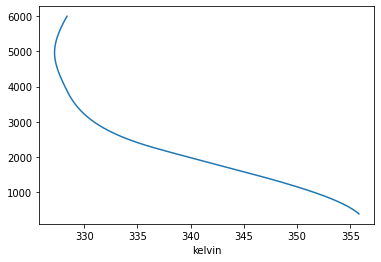

In [15]:
dcape_mm

NameError: name 'dcape_mm' is not defined

In [73]:
TV_env.shape

(50, 1015, 1367)

In [5]:
### loead test sounding data
data = np.load('/glade/u/home/prein/papers/2022_Wind-Changes/programs/sounding_test.npz')
p_hpa_com = data['p_hpa_com']
t_c_com = data['t_c_com']
dt_c_com = data['dt_c_com']
z_com = data['z_com']
qv_com = data['qv_com']

parcel = 'lowest-WBT' # 'lowest-WBT' '700hPa' '700-500hPa' 'lowest-ThetaE'

ES = 'Magnus'

dT = 0.2
delta_T = [0] #np.arange(-2, 4+dT, dT) #np.arange(-2,2,0.2)
dTstab = 0.04
delta_Tstab = [0] #np.arange(-0.24, 0.24+dTstab, dTstab) # np.arange(-0.24,0.24,0.02)
drh = 0.01
delta_RH = [0] #np.arange(-0.06, 0.06+drh, drh) #np.arange(-0.05,0.05,0.005)

cape_change = np.zeros((len(delta_T), len(delta_Tstab), len(delta_RH))); cape_change[:] = np.nan
cin_changes = np.copy(cape_change)
lcl_changes = np.copy(cape_change)
lfc_changes = np.copy(cape_change)
dcape_changes = np.copy(cape_change)
dcin_changes = np.copy(cape_change)

In [24]:
press_orig = (p_hpa_com * 100.)[:,None,None]
hght_orig = z_com[:,None,None]
tempC_orig = t_c_com[:,None,None]
tempK_orig = tempC_orig + 273.15
# qv = np.squeeze(DATA['QVAPOR'].values)
dewC_orig = dt_c_com[:,None,None]
mixrat_orig = qv_com[:,None,None]
rh_orig = metpy.calc.relative_humidity_from_dewpoint(tempC_orig * units.degreeC, dewC_orig * units.degreeC)
qv_orig = metpy.calc.mixing_ratio_from_relative_humidity(rh_orig, tempC_orig * units.degreeC, press_orig * units.hPa)

gr_env = {}
gr_par = {}
gr_tempC = {}
gr_dewC = {}
gr_rh = {}
for tt in tqdm(range(len(delta_T))):
    delta_t = 0 #delta_T[tt]
    for ts in range(len(delta_Tstab)):
        delta_tz = 0 #delta_Tstab[ts]
        for rr in range(len(delta_RH)):
            delta_rh = 0 #delta_RH[rr]
            name = str(np.round(delta_t,2))+'_'+str(np.round(delta_tz,2))+'_'+str(np.round(delta_rh,2))

            press = np.copy(press_orig)
            hght = np.copy(hght_orig)
            tempC = np.copy(tempC_orig) + delta_t + ((z_com[:,None,None]-z_com[0])/1000.)*delta_tz
            tempK = np.copy(tempC + 273.15)
            rh = np.copy(rh_orig) + delta_rh
            # qv = np.squeeze(DATA['QVAPOR'].values)
            
            gr_tempC[name] = tempC
            gr_rh[name] = rh

            # ballance dewpoint T
            dewC = np.array(metpy.calc.dewpoint_from_relative_humidity(tempC* units.degreeC, rh))
            mixrat = np.array(metpy.calc.mixing_ratio_from_relative_humidity(rh, tempC * units.degreeC, press * units.Pa))
            sfc_press = press[0,:,:]/100.
            gr_dewC[name] = dewC

            # DCAPE_origin function
            '''this is the lowest thetae value in the sfc-400mb layer'''
            #only eval levels at which the pressure is greater than 400mb 
            sfc_to_400 = np.copy(press[:,:,:])/100
            none = [sfc_to_400 < 400]
            sfc_to_400[none] = None
            tempK_t = np.copy(tempK[:,:,:])
            tempK_t[none] = None
            mixrat_t = np.copy(mixrat[:,:,:])
            mixrat_t[none] = None
            dewC_t = np.copy(dewC[:,:,:])
            dewC_t[none] = None
            hgt = np.copy(hght[:,:,:]).astype('float')
            # hgt[none] = None

            if parcel == '700-500hPa':
                # use average 700-500 hPa parcel for decent
                levels = (press >= 50000) & (press <= 70000)
                TK_ac = np.copy(tempK_t); TK_ac[levels == False] = None
                TK_ac = np.ma.MaskedArray(TK_ac, mask=np.isnan(TK_ac))
                Ppa_ac = np.copy(press); Ppa_ac[levels == False] = None
                Ppa_ac = np.ma.MaskedArray(Ppa_ac, mask=np.isnan(Ppa_ac))
                TdC_ac = np.copy(dewC_t); TdC_ac[levels == False] = None
                TdC_ac = np.ma.MaskedArray(TdC_ac, mask=np.isnan(TdC_ac))
                Q_ac = np.copy(mixrat_t); Q_ac[levels == False] = None
                Q_ac = np.ma.MaskedArray(Q_ac, mask=np.isnan(Q_ac))
                Z_ac = np.copy(hgt); Z_ac[levels == False] = None
                Z_ac = np.ma.MaskedArray(Z_ac, mask=np.isnan(Z_ac))

                TK_parcel = np.average(TK_ac, weights=Ppa_ac, axis=0)
                P_parcel = np.average(Ppa_ac, weights=Ppa_ac, axis=0)
                TdC_parcel = np.average(TdC_ac, weights=Ppa_ac, axis=0)
                Q_parcel = np.average(Q_ac, weights=Ppa_ac, axis=0)
                Z_parcel = np.average(Z_ac, weights=Ppa_ac, axis=0)
            if parcel == '700hPa':
                # use 700hPa parcel
                min_loc = np.argmin(np.abs(press - 70000), axis=0)
                j, k = np.indices(min_loc.shape)

                TK_parcel = tempK_t[min_loc, j, k]
                P_parcel = press[min_loc, j, k]
                TdC_parcel = dewC_t[min_loc, j, k]
                Q_parcel = mixrat_t[min_loc, j, k]
                Z_parcel = hgt[min_loc, j, k]
            if parcel == 'lowest-ThetaE':
                sfc_to_400 = np.copy(press[:,:,:])/100
                none = [sfc_to_400 < 400]
                sfc_to_400[none] = None
                tempK_t = np.copy(tempK[:,:,:])
                tempK_t[none] = None
                dewC_t = np.copy(dewC[:,:,:])
                dewC_t[none] = None
                mixrat_t = np.copy(mixrat[:,:,:])
                mixrat_t[none] = None
                hgt = np.copy(hght[:,:,:])
#                 hgt[none] = np.nan
                
                sfc_to_400_Te = metpy.calc.equivalent_potential_temperature(sfc_to_400*units.hPa,tempK_t*units.degK,dewC_t*units.degC)
                masked = np.ma.masked_array(sfc_to_400_Te, np.isnan(sfc_to_400_Te))
                min_loc, Te_min = np.nanargmin(masked, axis=0), np.nanmin(masked, axis=0)
                j, k = np.indices(min_loc.shape)
                
                TK_parcel = tempK_t[min_loc, j, k]
                P_parcel = Ppa_ac[min_loc, j, k]
                TdC_parcel = TdC_ac[min_loc, j, k]
                Q_parcel = Q_ac[min_loc, j, k]
                Z_parcel = Z_ac[min_loc, j, k]
            if parcel == 'lowest-WBT':
                # following the paper of Kastman et al 2018 - https://www.mdpi.com/2073-4433/9/9/339/htm
                # find min. wet butb temperature (WBT) in lowest 6 km
#                 wbt = metpy.calc.wet_bulb_temperature(press[:,:,:] * units.Pa, 
#                                                 tempK * units.K, 
#                                                 dewC * units.degC)
                wbt = wrf.wetbulb(press[:,:,:], 
                                      tempK, 
                                      mixrat, 
                                      meta=False, units='K').T
                thetae = metpy.calc.equivalent_potential_temperature(sfc_to_400*units.hPa,tempK_t*units.degK,dewC_t*units.degC)
    
                mask = hght[:,:,:] > 6000
                wbt[mask] = np.nan
                min_loc = np.nanargmin(thetae, axis=0)
                
                # this is the environmental temperature
                tempK_t = metpy.calc.virtual_temperature(tempK * units.K, 
                                                              mixrat)
                virtual_temp_sat = metpy.calc.virtual_temperature(dewC * units.degC, 
                                                              mixrat)
                j, k = np.indices(min_loc.shape)
                parcel_temp = np.copy(tempK); parcel_temp[:] = np.nan
                parcel_temp[min_loc, j, k] = wbt[min_loc, j, k]
                hgt = np.copy(hght[:,:,:])
                
            # all methods except the 'lowest-WBT' use the LCL for parcel properties
            if parcel != 'lowest-WBT':
                # find the lifting condensation level of all parcels
                # use https://earthscience.stackexchange.com/questions/13564/how-do-you-calculate-the-elevation-at-which-clouds-will-form-lifting-condensati
                dT_minus_T = (TK_parcel - 273.15) - TdC_parcel
                lapsrate_diff = 9.8-2 # °C per km
                # the Saturated Adiabatic Lapse Rate is approximated to 2 °C per km
                LCL = dT_minus_T/lapsrate_diff
                TC_at_lcl = (TK_parcel - 273.15) - LCL*9.8
                heigt_at_lcl = LCL*1000. + Z_parcel

                # find index of LCL heigt and create parcel temperature array
                array = np.abs(heigt_at_lcl[None,:,:] - hgt)
                min_loc = np.nanargmin(array, axis=0)
                parcel_temp = np.copy(tempK_t); parcel_temp[:] = np.nan
                j, k = np.indices(min_loc.shape)
                parcel_temp[min_loc, j, k] = TC_at_lcl+273.15
            
            
            pp = np.copy(press)[::-1] #; pp[hgt > heigt_at_lcl] = None; pp = pp[::-1]
            tk = np.copy(tempK_t)[::-1] #; tk[hgt > heigt_at_lcl] = None; tk = tk[::-1]
            qv_al = np.copy(mixrat_t)[::-1] #; qv_al[hgt > heigt_at_lcl] = None; qv_al = qv_al[::-1]
            hgt = np.copy(hgt)[::-1]
            parcel_temp = parcel_temp[::-1]

            ## Create the parcel profile for decent along a moist adiabat
            # # #  # # # #  # # #  # # # #  # # # # # #  # #  #  # #  # # 
            #calc parcel path temps (aka moist adiabtic descent) 
#             parcel_temp = np.copy(tk[:,:,:])
            for i in range(1, parcel_temp.shape[0]):
                if np.isnan(parcel_temp[i-1]) == True:
                    continue
                dz= hgt[i-1]-hgt[i] #new height - previous height                
                new_temp=[moist_lapse(parcel_temp[i-1], pp[i-1]/100., dz, ES)]
                parcel_temp[i,:,:] = new_temp

                nan = np.isnan(new_temp)[0,:]
                if len(parcel_temp.shape) == 1:
                    if nan == True:
                        parcel_temp[i-1] = parcel_temp[i-1]
                        parcel_temp[i] = parcel_temp[i]
                else:
                    parcel_temp[i-1][nan] = parcel_temp[i-1][nan]
                    parcel_temp[i][nan] = parcel_temp[i][nan]

            #convert to Celcius   
            pa_t = parcel_temp - 273.15
            #attach a new column of the parcel temps to the pandas dataframe
            # DD_layer['p_tempC'], DD_layer['p_tempK'] = pa_t, parcel_temp
#             TV_env = np.array(metpy.calc.virtual_temperature(tk * units.degreeK, qv_al))-273.15
            qv_parcel = metpy.calc.saturation_mixing_ratio(pp * units.hPa, parcel_temp * units.degreeK)
            TV_par = np.array(metpy.calc.virtual_temperature(parcel_temp * units.degreeK, qv_parcel))-273.15
            TV_env = np.copy(tk)
            TV_env[np.isnan(TV_par) == True] = np.nan
            TV_env = np.array(TV_env) - 273.15
            
            gr_env[name] = TV_env
            gr_par[name] = TV_par
#             TV_env = Virtual_Temp(pp, tk, ES)
#             TV_par = Virtual_Temp(pp, parcel_temp, ES)
            ############

            ## Calculate the difference in profile and environmental temperature to integrate
            evn_par_diff = np.array(TV_env - TV_par)

            # Calculate DCAPE
            evn_par_diff[np.isnan(evn_par_diff)] = 0
            dcape_pp = np.copy(evn_par_diff)
            dcape_pp[dcape_pp < 0] = 0
            dcin_pp = np.copy(evn_par_diff)
            dcin_pp[dcin_pp > 0] = 0
            log_pp = np.log(pp)
            log_pp[np.isnan(log_pp)] = 0
            dcape = (0.2870579959589441 * (np.trapz(dcape_pp, x=log_pp, axis=0)))*1000
            dcin = (0.2870579959589441 * (np.trapz(np.abs(dcin_pp), x=log_pp, axis=0)))*1000

            ### calculate CAPE as well
            import wrf
            cape = wrf.cape_2d(press[:,0,0]/100, tempK[:,0,0], mixrat[:,0,0], hght[:,0,0], hght[0,0,0], press[0]/100., 
                        ter_follow = False)
            cape_change[tt,ts,rr] = cape[0]
            cin_changes[tt,ts,rr] = cape[1]
            lcl_changes[tt,ts,rr] = cape[2]
            lfc_changes[tt,ts,rr] = cape[3]
            dcape_changes[tt,ts,rr] = np.squeeze(dcape)
            dcin_changes[tt,ts,rr] = np.squeeze(dcin)

100%|██████████| 1/1 [00:00<00:00, 19.80it/s]


In [25]:
np.squeeze(dcape)

array(1495.15223165)

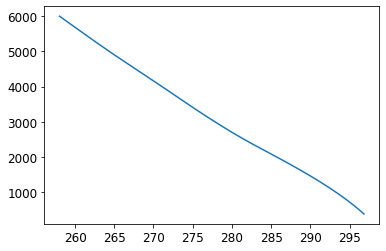

In [22]:
plt.plot(wbt.flatten()[::-1], hgt.flatten())

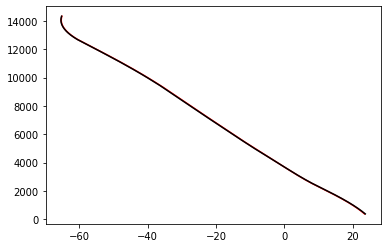

In [50]:
plt.plot(np.array(wbt[:,0,0])-273.15, hght[:,0,0], c='r')
plt.plot(np.array(wbt_wrf.T[:,0,0])-273.15, hght[:,0,0], c='k')

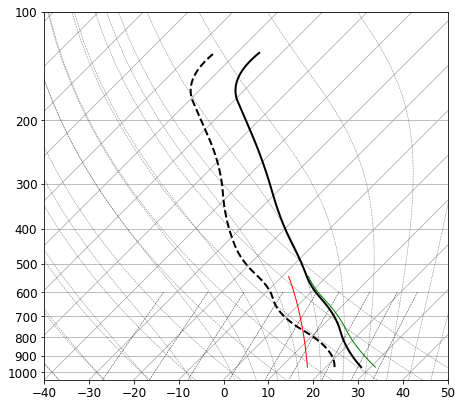

In [27]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 12})
left = 0.4
right = 0.78
names = list(gr_dewC.keys())

# ###########################
# skew-T diagram
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05, right=left-0.07,
   bottom=0.05, top=0.95,
   wspace=0.3, hspace=0.3)

skew = SkewT(fig, rotation=45, subplot=gs1[0,0])
# Add the relevant special lines
skew.plot_dry_adiabats(color='k', lw=0.5)
skew.plot_moist_adiabats(color='k', lw=0.5)
skew.plot_mixing_lines(color='k', lw=0.5)
# ax = plt.subplot(gs1[0,0])
# skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p_hpa_com, t_c_com, 'k', linewidth=2)
skew.plot(p_hpa_com, dt_c_com, 'k', linewidth=2, ls='--')

env_te = np.array(np.squeeze(gr_env[names[0]]))[::-1]
par_te = np.array(np.squeeze(gr_par[names[0]]))[::-1]
skew.plot(p_hpa_com, env_te, 'g', linewidth=1)
skew.plot(p_hpa_com, par_te, 'r', linewidth=1)


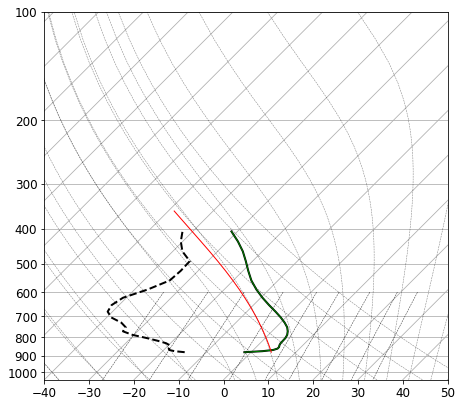

In [79]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 12})
left = 0.4
right = 0.78
names = list(gr_dewC.keys())

lon = 600
lat = 500

# ###########################
# skew-T diagram
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05, right=left-0.07,
   bottom=0.05, top=0.95,
   wspace=0.3, hspace=0.3)

skew = SkewT(fig, rotation=45, subplot=gs1[0,0])
# Add the relevant special lines
skew.plot_dry_adiabats(color='k', lw=0.5)
skew.plot_moist_adiabats(color='k', lw=0.5)
skew.plot_mixing_lines(color='k', lw=0.5)
# ax = plt.subplot(gs1[0,0])
# skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(press[:,lat,lon]/100, tempK_t[:,lat,lon]-273.15, 'k', linewidth=2)
skew.plot(press[:,lat,lon]/100, dewC_t[:,lat,lon], 'k', linewidth=2, ls='--')

env_te = np.array(np.squeeze(gr_env[names[0]]))[::-1]
par_te = np.array(np.squeeze(gr_par[names[0]]))[::-1]
skew.plot(press[:,lat,lon]/100, TV_env[::-1,lat,lon], 'g', linewidth=1)
skew.plot(press[:,lat,lon]/100, TV_par[::-1,lat,lon], 'r', linewidth=1)


In [89]:
DataFolder = '/glade/campaign/ncar/USGS_Water/CONUS404/'

dcape_mm = np.zeros((len(TimeHH),lon_wrf.shape[0],lon_wrf.shape[1]), dtype=np.float32)
dcin_mm = np.copy(dcape_mm)

for hh in tqdm(range(len(TimeHH))):
    YYYY = TimeHH[hh].year
    MM = TimeHH[hh].month
    if MM >= 10:
        WY = YYYY+1
    else:
        WY = YYYY
    file = DataFolder + 'WY'+str(WY) + '/wrf3d_d01_'+ str(YYYY) +\
                                        '-'+ str(MM).zfill(2)+ \
                                        '-'+ str(TimeHH[hh].day).zfill(2)+ \
                                        '_'+ str(TimeHH[hh].hour).zfill(2) + ':00:00'
    DATA = xr.open_dataset(file)
    DATA = DATA[Variables]
        
    press = np.squeeze(DATA['P'].values)
    hght = np.squeeze(DATA['Z'].values)
    hght = (hght[1:,:,:] + hght[:-1,:,:])/2
    tempK = np.squeeze(DATA['TK'].values)
    tempC = tempK - 273.15
    qv = np.squeeze(DATA['QVAPOR'].values)
    dewC = np.array(wrf.td(press/100., qv))
    rh = metpy.calc.relative_humidity_from_dewpoint(tempC * units.degreeC, dewC * units.degreeC)
    mixrat = np.array(metpy.calc.mixing_ratio_from_relative_humidity(rh, tempC * units.degreeC, press * units.Pa))
#     # layer_group
#     Te = tempK * (100000/press)**0.286
    
    sfc_press = press[0,:,:]/100.

    # DCAPE_origin function
    '''this is the lowest thetae value in the sfc-400mb layer'''
    #only eval levels at which the pressure is greater than 400mb 
    sfc_to_400 = np.copy(press[:,:,:])/100
    none = [sfc_to_400 < 400]
    sfc_to_400[none] = None
    tempK_t = np.copy(tempK[:,:,:])
    tempK_t[none] = None
    dewC_t = np.copy(dewC[:,:,:])
    dewC_t[none] = None
    mixrat_t = np.copy(mixrat[:,:,:])
    mixrat_t[none] = None
    hgt = np.copy(hght[:,:,:])
    hgt[none] = None

    #find the thetae-e at all the levels that matched the above criteria
    # sfc_to_400_Te = thetae(sfc_to_400, tempK_t, ES) 
    sfc_to_400_Te = metpy.calc.equivalent_potential_temperature(sfc_to_400*units.hPa,tempK_t*units.degK,dewC_t*units.degC)
    # sfc_to_400_Te = tempK_t * (100000/(sfc_to_400*100))**0.286

    #find which level the min thetae occurs at (from sfc to 400mb)
    masked = np.ma.masked_array(sfc_to_400_Te, np.isnan(sfc_to_400_Te))
    row_oforig, Te_min = np.nanargmin(masked, axis=0), np.nanmin(masked, axis=0)
    j, k = np.indices(row_oforig.shape)
    upper_press = sfc_to_400[row_oforig, j, k]


    # DD_CAPE_CALC function
    # Trim data to only consider the levels within the identified layer
    # Flip order of the data to capture the descending motion of the parcel
    active_layer = (sfc_to_400 <= sfc_press) & (sfc_to_400 >= upper_press)
    pp = np.copy(sfc_to_400); pp[active_layer == False] = None; pp = pp[::-1]
    tk = np.copy(tempK_t); tk[active_layer == False] = None; tk = tk[::-1]
    qv_al = np.copy(mixrat_t); qv_al[active_layer == False] = None; qv_al = qv_al[::-1]
    hgt[active_layer == False] = None; hgt = hgt[::-1]

    ## Create the parcel profile for decent along a moist adiabat
    # # #  # # # #  # # #  # # # #  # # # # # #  # #  #  # #  # # 
    #calc parcel path temps (aka moist adiabtic descent) 
    parcel_temp = np.array([tk[0]])
    for i in range(1, tk.shape[0]):
        dz= hgt[i-1]-hgt[i] #new height - previous height
        new_temp=[moist_lapse(parcel_temp[i-1], pp[i-1], dz, ES)]
        parcel_temp = np.append(parcel_temp, new_temp, axis=0)
        nan = np.isnan(new_temp)[0,:]
        if len(parcel_temp.shape) == 1:
            if nan == True:
                parcel_temp[i-1] = tk[i-1]
                parcel_temp[i] = tk[i]
        else:
            parcel_temp[i-1][nan] = tk[i-1][nan]
            parcel_temp[i][nan] = tk[i][nan]

    #convert to Celcius   
    pa_t = parcel_temp - 273.15
    #attach a new column of the parcel temps to the pandas dataframe
    # DD_layer['p_tempC'], DD_layer['p_tempK'] = pa_t, parcel_temp
#     TV_env = Virtual_Temp(pp, tk, ES)
#     TV_par = Virtual_Temp(pp, parcel_temp, ES)
    TV_env = metpy.calc.virtual_temperature(tk * units.degreeK, qv_al)
    qv_parcel = metpy.calc.saturation_mixing_ratio(pp * units.hPa, parcel_temp * units.degreeK)
    TV_par = metpy.calc.virtual_temperature(parcel_temp * units.degreeK, qv_parcel)
    ############

    ## Calculate the difference in profile and environmental temperature to integrate
    evn_par_diff = np.array(TV_env - TV_par)

    # Calculate DCAPE
    evn_par_diff[np.isnan(evn_par_diff)] = 0
    dcape_pp = np.copy(evn_par_diff)
    dcape_pp[dcape_pp < 0] = 0
    dcin_pp = np.copy(evn_par_diff)
    dcin_pp[dcin_pp > 0] = 0
    log_pp = np.log(pp)
    log_pp[np.isnan(log_pp)] = 0
    dcape_mm[hh,:,:] = (0.2870579959589441 * (np.trapz(dcape_pp, x=log_pp, axis=0)))*1000
    dcin_mm[hh,:,:] = (0.2870579959589441 * (np.trapz(np.abs(dcin_pp), x=log_pp, axis=0)))*1000
    

array([[260.7092093]])